In [18]:
# 쉬는날을 찾기

import random
import pandas as pd
import numpy as np
import os
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings(action='ignore') 
korea_holidays = holidays.SouthKorea(years=2023)

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [8]:
train = pd.read_csv('./open/train.csv')
train['timestamp'] = pd.to_datetime(train['timestamp'])
train = train.set_index('timestamp')
split_data = [i.reset_index() for i in pd.DataFrame(train.resample('3M'))[1]]
split_data[0]

,timestamp,ID,item,corporation,location,supply(kg),price(원/kg)
0,2019-01-01,TG_A_J_20190101,TG,A,J,0.0,0.0
1,2019-01-01,TG_A_S_20190101,TG,A,S,0.0,0.0
2,2019-01-01,TG_B_J_20190101,TG,B,J,0.0,0.0
3,2019-01-01,TG_B_S_20190101,TG,B,S,0.0,0.0
4,2019-01-01,TG_C_J_20190101,TG,C,J,0.0,0.0
...,...,...,...,...,...,...,...
1204,2019-01-31,BC_D_J_20190131,BC,D,J,2584.0,2052.0
1205,2019-01-31,BC_E_J_20190131,BC,E,J,6360.0,1963.0
1206,2019-01-31,BC_E_S_20190131,BC,E,S,2296.0,2129.0
1207,2019-01-31,CB_F_J_20190131,CB,F,J,243736.0,396.0


In [41]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

target = []
for date, name in sorted(korea_holidays.items()):
    target.append(str(date))
train['Isholiday'] = train['timestamp'].apply(lambda x: 1 if x in target else 0)
test['Isholiday'] = test['timestamp'].apply(lambda x: 1 if x in target else 0)

train = train.drop(train[(train['supply(kg)'] > 0) & (train['price(원/kg)'] == 0)].index)
train = train.reset_index(drop=True)

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
train['Is_Sunday'] = train['timestamp'].dt.day_name() == 'Sunday'
test['Is_Sunday'] = test['timestamp'].dt.day_name() == 'Sunday'

# no supply -> no price
# train['classify'] = train['supply(kg)'].apply(lambda x: 0 if x == 0 else 1)
train['Is_Sunday'] = train['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    
test['Is_Sunday'] = test['Is_Sunday'].apply(lambda x: 0 if x == False else 1)
tar = train[(train['Is_Sunday'] == 1) & (train['price(원/kg)'] > 0)].index
train = train.drop(tar)

train['timestamp'] = train['timestamp'].astype('str')
train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))
train['day'] = train['timestamp'].apply(lambda x : int(x[8:10]))

test['timestamp'] = test['timestamp'].astype('str')
test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))
test['day'] = test['timestamp'].apply(lambda x : int(x[8:10]))

qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])
    test[i]=le.transform(test[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

train = train.drop(['supply(kg)','ID','timestamp'],axis=1)
test = test.drop(['timestamp'],axis=1) # ID

train = train[train['price(원/kg)'] < 7500].reset_index(drop=True)

print('Done.')

Done.


In [40]:
le = OneHotEncoder()
le.fit_transform(np.array(train['item']).reshape(-1,1))
le.

array(['x0_BC', 'x0_CB', 'x0_CR', 'x0_RD', 'x0_TG'], dtype=object)

In [10]:
tp1 = train[(train['year'] == 2019) & (train['month'] == 3) & (train['day'] > 3)]
tp2 = train[(train['year'] == 2020) & (train['month'] == 3) & (train['day'] > 3)]
tp3 = train[(train['year'] == 2021) & (train['month'] == 3) & (train['day'] > 3)]
tp4 = train[(train['year'] == 2022) & (train['month'] == 3) & (train['day'] > 3)]

val1 = tp1.drop('price(원/kg)',axis=1)
val2 = tp2.drop('price(원/kg)',axis=1)
val3 = tp3.drop('price(원/kg)',axis=1)
val4 = tp4.drop('price(원/kg)',axis=1)

actual1 = tp1['price(원/kg)']
actual2 = tp2['price(원/kg)']
actual3 = tp3['price(원/kg)']
actual4 = tp4['price(원/kg)']

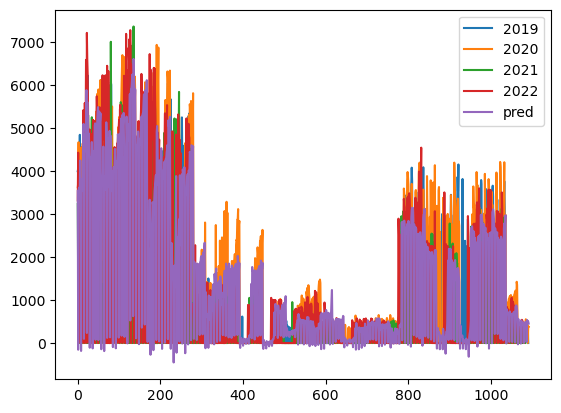

In [11]:
train[(train['year'] == 2019) & (train['day'] > 3) &
      (train['month'] == 3)]['price(원/kg)'].reset_index(drop=True).plot()
train[(train['year'] == 2020) & (train['day'] > 3) &
      (train['month'] == 3)]['price(원/kg)'].reset_index(drop=True).plot()
train[(train['year'] == 2021) & (train['day'] > 3) &
      (train['month'] == 3)]['price(원/kg)'].reset_index(drop=True).plot()
train[(train['year'] == 2022) & (train['day'] > 3) &
      (train['month'] == 3)]['price(원/kg)'].reset_index(drop=True).plot()
pd.read_csv('./rg-scale.csv')['answer'].plot()

plt.legend(['2019','2020','2021','2022','pred'])

In [12]:
train_location1 = pd.DataFrame(pd.DataFrame(train.groupby('location'))[1][0]).reset_index(drop=True)
train_location2 = pd.DataFrame(pd.DataFrame(train.groupby('location'))[1][1]).reset_index(drop=True)

test_location1 = pd.DataFrame(pd.DataFrame(test.groupby('location'))[1][0]).reset_index(drop=True)
test_location2 = pd.DataFrame(pd.DataFrame(test.groupby('location'))[1][1]).reset_index(drop=True)

train_location1 = train_location1[(train_location1['month'] == 2) |
                                 (train_location1['month'] == 3) |
                                 (train_location1['month'] == 4)]

In [13]:
from pycaret import regression
regression.setup(data=train,target='price(원/kg)'
                     ,train_size=0.9
                     ,fold=10
                     ,session_id=42)

,Description,Value
0,Session id,42
1,Target,price(원/kg)
2,Target type,Regression
3,Original data shape,"(58243, 9)"
4,Transformed data shape,"(58243, 9)"
5,Transformed train set shape,"(52418, 9)"
6,Transformed test set shape,"(5825, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [14]:
best = regression.compare_models(n_select=10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,265.4489,537744.5221,732.7273,0.8209,2.0608,0.1877,1.2370
xgboost,Extreme Gradient Boosting,376.2729,573398.3125,756.9609,0.8090,3.7249,0.2488,0.7380
et,Extra Trees Regressor,254.7811,579231.9298,760.3941,0.8071,1.8795,0.1833,1.0620
catboost,CatBoost Regressor,391.2891,589825.0621,767.7828,0.8035,3.7858,0.2578,2.8060
lightgbm,Light Gradient Boosting Machine,373.7775,591551.0113,768.8954,0.8029,3.5279,0.2696,0.1060
dt,Decision Tree Regressor,299.0934,876503.3295,935.5935,0.7080,2.0248,0.2329,0.0360
gbr,Gradient Boosting Regressor,548.6735,894751.6471,945.6964,0.7019,4.2029,0.3438,0.6600
knn,K Neighbors Regressor,535.2503,899719.2562,948.3483,0.7002,3.4423,0.3847,0.0760
ada,AdaBoost Regressor,782.7941,1323658.0323,1150.3040,0.5588,4.7264,0.3856,0.1860
br,Bayesian Ridge,1152.9777,2477834.6244,1573.9621,0.1741,5.1602,0.8617,0.0190


In [15]:
def prediction(val):
    pred =  0.6*best[0].predict(val) + 0.2*best[1].predict(val) + 0.2*best[2].predict(val)
    return pred

# pred1 = prediction(val1)
# pred2 = prediction(val2)
# pred3 = prediction(val3)
# pred4 = prediction(val4)

# def cross_metric(act,pred):
#     rmse = np.sqrt(mean_squared_error(act,pred))
#     print(f"RMSE : {rmse}")
#     print('')

# cross_metric(actual1,pred1) # 2019 3
# cross_metric(actual2,pred2) # 2020 3
# cross_metric(actual3,pred3) # 2021 3
# cross_metric(actual4,pred4) # 2022 3


In [16]:
prediction(test.drop('ID',axis=1))


array([3567.72288672,   24.23554039, 3798.52371387, ...,  471.09629016,
        495.30537109,  515.37232782])

In [294]:
# for i in test_location1.index:
#     target.loc[i,'answer'] = test_location1.loc[i,'answer']
# target = target.reset_index()

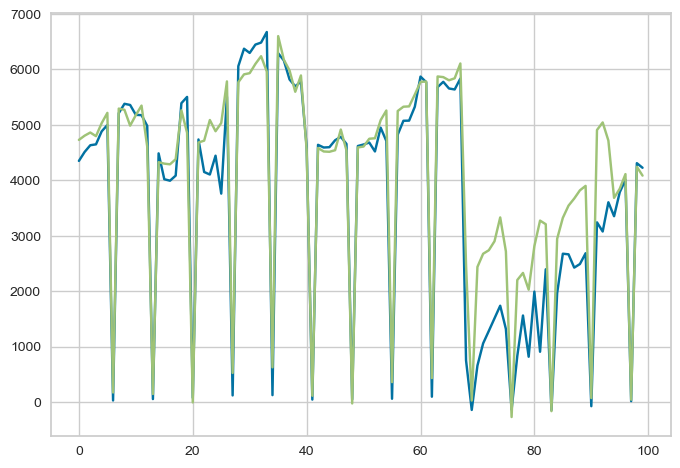

<Axes: >

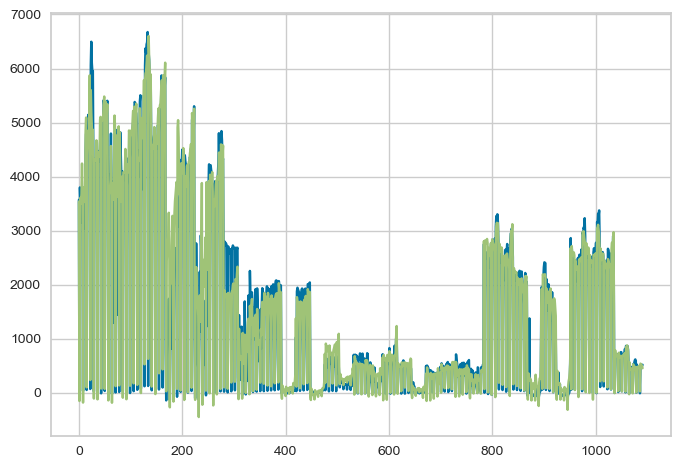

In [17]:
confirm_interval = 1
plt.plot(prediction(test.drop('ID',axis=1))[100*confirm_interval:100*(confirm_interval+1)])
pd.read_csv('./rg-scale.csv')['answer'][100*confirm_interval:100*(confirm_interval+1)].reset_index(drop=True).plot()
plt.show()
plt.plot(prediction(test.drop('ID',axis=1)))
pd.read_csv('./rg-scale.csv')['answer'].reset_index(drop=True).plot()


In [297]:
submission = pd.read_csv('./open/sample_submission.csv')
submission['answer'] = prediction(test.drop('ID',axis=1)) 
submission.to_csv('./cut_price_7000.csv', index=False)


In [159]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

target = []
for date, name in sorted(korea_holidays.items()):
    target.append(str(date))
train['Isholiday'] = train['timestamp'].apply(lambda x: 1 if x in target else 0)
test['Isholiday'] = test['timestamp'].apply(lambda x: 1 if x in target else 0)

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
train['Is_Sunday'] = train['timestamp'].dt.day_name() == 'Sunday'
test['Is_Sunday'] = test['timestamp'].dt.day_name() == 'Sunday'
train['Is_Sunday'] = train['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    
test['Is_Sunday'] = test['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    


tar = train[(train['Is_Sunday'] == 1) & (train['price(원/kg)'] > 0)].index
train = train.drop(tar)
train

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),Isholiday,Is_Sunday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,0,0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,0,0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,0,0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,0,0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,0,0
...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,0,0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,0,0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,1,0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,0,0


<Axes: ylabel='answer'>

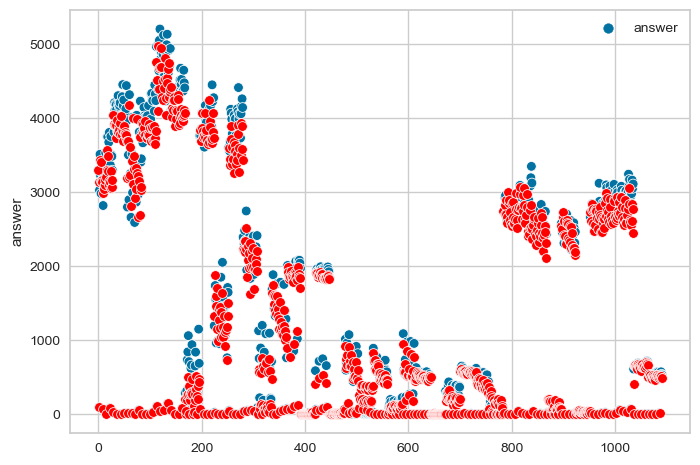

In [107]:

sns.scatterplot(data=pd.read_csv('./location-split-reg.csv'))
sns.scatterplot(data=pd.read_csv('./reg-ts28-best-0cut.csv')['answer'],color='red')


<Axes: ylabel='answer'>

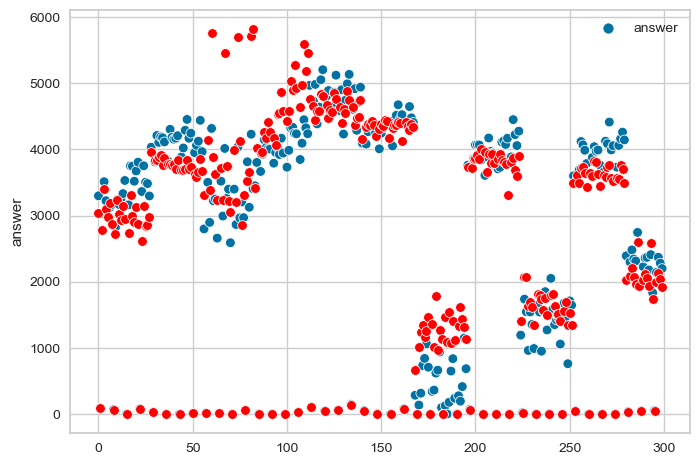

In [153]:
import seaborn as sns
pt = 0
sns.scatterplot(data=pd.read_csv('./location-split-reg.csv')[300*pt:300*(pt+1)])
sns.scatterplot(data=pd.read_csv('./corp-split-reg.csv')['answer'][300*pt:300*(pt+1)],color='red')
# sns.scatterplot(data=pd.read_csv('./item-split.csv')['answer'][200*pt:200*(pt+1)],color='green')

In [148]:
sub = pd.read_csv('./open/sample_submission.csv')
sub['idx'] = sub['ID'].apply(lambda x:str(x[:6]))
sub[sub['idx'] == 'TG_E_J']

,ID,answer,idx
550,CB_D_J_20230322,0,CB_D_J
551,CB_D_J_20230323,0,CB_D_J
552,CB_D_J_20230324,0,CB_D_J
553,CB_D_J_20230325,0,CB_D_J
554,CB_D_J_20230326,0,CB_D_J
555,CB_D_J_20230327,0,CB_D_J
556,CB_D_J_20230328,0,CB_D_J
557,CB_D_J_20230329,0,CB_D_J
558,CB_D_J_20230330,0,CB_D_J
559,CB_D_J_20230331,0,CB_D_J


In [ ]:
# CRDS,CBAS,CRES,BCBS,BCCS,RDCS

In [123]:
tp = pd.read_csv('./open/train.csv')
tp['timestamp'] = pd.to_datetime(tp['timestamp'])
tp = tp[tp['timestamp'].dt.month==3]
tp.groupby(['item','corporation','location']).mean()

supply(kg)  price(원/kg)
item corporation location                            
BC   A           J           6822.011811  2342.496063
                 S           2839.307087  2270.858268
     B           J            707.165354  1930.275591
                 S             60.913386   553.795276
     C           J            276.614173  1677.480315
                 S             11.023622   125.976378
     D           J           1526.472441  2188.472441
     E           J           4497.692913  2256.629921
                 S           1151.055118  2207.842520
CB   A           J           3521.015748   330.133858
                 S            591.937008    68.834646
     D           J          11318.724409   445.692913
     E           J           7760.771654   497.086614
     F           J         186204.291339   577.905512
CR   A           J           9188.314961   668.944882
     B           J           2996.692913   398.496063
     C           J           4055.590551   695.110236
     D           J          32742.519685  1048.385827
                 S             38.740157     4.842520
     E           J          30823.228346   934.952756
                 S             78.740157     5.881890
RD   A           J          16508.574803   353.755906
                 S          20148.661417   302.881890
     C           S            406.299213    14.141732
     D           J          12579.385827   315.212598
                 S          17990.157480   351.039370
     E           J           7940.314961   306.055118
                 S           2575.275591   225.582677
     F           J         377511.181102   332.102362
TG   A           J           3361.537795  3215.417323
                 S          19686.653543  3854.338583
     B           J           4191.219528  3073.661417
                 S          10307.177559  3638.338583
     C           J           2973.481890  4198.000000
                 S          19849.046457  3724.574803
     D           J           1129.019685  2565.598425
                 S           4856.012598  3628.889764
     E           J           1016.598425  1780.251969
                 S           6703.811024  3316.984252

In [115]:
print(pd.read_csv('./open/train.csv').groupby('item').mean())
print(pd.read_csv('./open/train.csv').groupby('item').max())
print(pd.read_csv('./open/train.csv').groupby('item').min())

        supply(kg)  price(원/kg)
item                           
BC     1000.060071   910.196615
CB    11241.532567   152.187131
CR     5054.161992   273.118938
RD    27670.840003   187.073539
TG    14193.242484  3177.442022
                   ID   timestamp corporation location  supply(kg)  \
item                                                                 
BC    BC_E_S_20230303  2023-03-03           E        S     30304.0   
CB    CB_F_J_20230303  2023-03-03           F        S    337122.0   
CR    CR_E_S_20230303  2023-03-03           E        S    236600.0   
RD    RD_F_J_20230303  2023-03-03           F        S   1222800.0   
TG    TG_E_S_20230303  2023-03-03           E        S    271156.0   

      price(원/kg)  
item               
BC         8750.0  
CB         2500.0  
CR         3882.0  
RD         5715.0  
TG        20909.0  
                   ID   timestamp corporation location  supply(kg)  \
item                                                                 
BC   

In [155]:
tp = pd.read_csv('./location-split-reg.csv')
tp[tp['answer'] < 0]

,ID,answer
